In [1]:
import os
import pandas as pd

In [2]:
# Get the directory with the notebooks, including its subdirectories
current_dir = os.getcwd()

# Get the directories with data and results
data_dir = os.path.join(current_dir, "data")
temporary_dir= os.path.join(current_dir, "temporary_data")
results_dir = os.path.join(current_dir, "results")

project_dir = os.path.dirname(current_dir)

print(project_dir, current_dir, results_dir, data_dir)

/home/xternava/Documents/GitHub/bloat-energy-consumption /home/xternava/Documents/GitHub/bloat-energy-consumption/notebooks /home/xternava/Documents/GitHub/bloat-energy-consumption/notebooks/results /home/xternava/Documents/GitHub/bloat-energy-consumption/notebooks/data


In [12]:
# Using this function, the purpose is to cancatenate all generated measurements for each repeated experiment 
def concatenate_csv_files(directory_path, output_file):
    file_list = os.listdir(directory_path)
    csv_files = [file for file in file_list if file.endswith(".csv")]

    if not csv_files:
        print("No CSV files found in the directory.")
        return

    dfs = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path, delimiter=';') # This is important, the delimiter
        
        filename_parts = file[:-4].split("_")  # Split filename and remove ".csv" extension        
        df['Program'] = filename_parts[0].split("-")[0]
        df['TestNr'] = filename_parts[0].split("-")[1]
        df['Utilities'] = filename_parts[1]
        dfs.append(df)

    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.to_csv(output_file, index=False, sep=';')  # Use semicolon as delimiter

    print(f"CSV files concatenated and saved to '{output_file}'.")

# All data into files in the folder save in a new CSV file
input_data = os.path.join(data_dir, 'repeat10/') # You need to change this for each new folder that you want to concatenate its files
output_data = os.path.join(results_dir, 'cat_repeat10.csv') # You need to change this for each new folder given above

concatenate_csv_files(input_data, output_data)

CSV files concatenated and saved to '/home/xternava/Documents/GitHub/bloat-energy-consumption/notebooks/results/cat_repeat10.csv'.


In [14]:
# Using this function, the purpose is to concatenate all resulting files from all 5 executions
def concatenate_allcsv_files(directory_path, output_file):
    file_list = os.listdir(directory_path)
    csv_files = [file for file in file_list if file.endswith(".csv")]

    if not csv_files:
        print("No CSV files found in the directory.")
        return

    dfs = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path, delimiter=';') # This is important, the delimiter
        df['Repetition'] = file  # Add filename as a new column
        dfs.append(df)

    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.to_csv(output_file, index=False, sep=';')  # Use semicolon as delimiter


    print(f"CSV files concatenated and saved to '{output_file}'.")

# Save in a new CSV file
output_alldata = os.path.join(results_dir, 'cat_all_repeats.csv')

concatenate_allcsv_files(temporary_dir, output_alldata)

CSV files concatenated and saved to '/home/xternava/Documents/GitHub/bloat-energy-consumption/notebooks/results/cat_all_repeats.csv'.


In [15]:
# Now we need to find the average value of PSYS for all measurements of a program 
def calculate_average_PSYS(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file, delimiter=';')
    
    # Calculate average of 'PSYS' column for each unique combination of 'Program' and 'Utilities'
    average_psys = df.groupby(['Program', 'Utilities'])['PSYS'].mean().reset_index()
    
    # Write the average values to a new file separated with a semicolon
    average_psys.to_csv(output_file, index=False, sep=';')
    
    print(f"Average PSYS values written to '{output_file}'.")

# Required inputs and outputs
input_data = os.path.join(results_dir, 'cat_all_repeats.csv')
output_data = os.path.join(results_dir, 'averagePSYS_all_repeats.csv')

calculate_average_PSYS(input_data, output_data)


Average PSYS values written to '/home/xternava/Documents/GitHub/bloat-energy-consumption/notebooks/results/averagePSYS_all_repeats.csv'.


In [17]:
# Now we need to find the average value of PSYS and DURATION for all measurements of a program 
def calculate_average_PSYS_DURATION(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file, delimiter=';')
    
    # Calculate average of 'PSYS' column for each unique combination of 'Program' and 'Utilities'
    average_psys = df.groupby(['Program', 'Utilities'])['PSYS'].mean().reset_index()
    
    # Calculate average of 'DURATION' column for each unique combination of 'Program' and 'Utilities'
    average_duration = df.groupby(['Program', 'Utilities'])['DURATION'].mean().reset_index()
    
    # Merge the two DataFrames based on 'Program' and 'Utilities'
    merged_df = pd.merge(average_psys, average_duration, on=['Program', 'Utilities'])
    
    # Write the average values to a new file separated with a semicolon
    merged_df.to_csv(output_file, index=False, sep=';')
    
    print(f"Average PSYS and DURATION values written to '{output_file}'.")

# Required inputs and outputs
input_data = os.path.join(results_dir, 'cat_all_repeats.csv')
output_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')

calculate_average_PSYS_DURATION(input_data, output_data)

Average PSYS and DURATION values written to '/home/xternava/Documents/GitHub/bloat-energy-consumption/notebooks/results/averageDURATION_all_repeats.csv'.


In [18]:
# After we need to put together the PSYS and Size values for each program in each of the 3 different implementations

csv_with_ec = os.path.join(results_dir, 'averagePSYS_all_repeats.csv')
csv_with_size = os.path.join(project_dir, 'pre-experiment/programs.csv') 
output_file = os.path.join(results_dir, 'all_ec_bsize.csv')

# Read the first CSV file
df1 = pd.read_csv(csv_with_ec, delimiter=';')

# Read the second CSV file
df2 = pd.read_csv(csv_with_size, delimiter=';')

# Merge the two DataFrames based on 'Program' column
merged_df = pd.merge(df1, df2, on='Program')

# Add the 'Size' values for each 'Utilities' based on the Program and fillna with 0 if not found
df1['Size'] = merged_df.apply(lambda row: row[row['Utilities']], axis=1)

# Save the final DataFrame to a new CSV file, including 'Utilities' and 'PSYS' columns
df1.to_csv(output_file, index=False, sep=';')


In [19]:
# After we need to put together the PSYS and number of Configuration Options for each program in each of the 3 different implementations

csv_with_ec = os.path.join(results_dir, 'averagePSYS_all_repeats.csv')
csv_with_size = os.path.join(project_dir, 'pre-experiment/programs_nr_options.csv') 
output_file = os.path.join(results_dir, 'all_ec_options.csv')

# Read the first CSV file
df1 = pd.read_csv(csv_with_ec, delimiter=';')

# Read the second CSV file
df2 = pd.read_csv(csv_with_size, delimiter=';')

# Merge the two DataFrames based on 'Program' column
merged_df = pd.merge(df1, df2, on='Program')

# Add the 'Size' values for each 'Utilities' based on the Program and fillna with 0 if not found
df1['Options'] = merged_df.apply(lambda row: row[row['Utilities']], axis=1)

# Save the final DataFrame to a new CSV file, including 'Utilities' and 'PSYS' columns
df1.to_csv(output_file, index=False, sep=';')


In [20]:
# Now we want to calculate the Peason correlation between the EC and Size 
# for all utilities in each 3 different implementations

# The Spearman correlation with the p-value

import pandas as pd
from scipy.stats import spearmanr

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['Size']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Spearman Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

           Spearman Correlation   p-value
Utilities                                
BusyBox                0.304741  0.114844
GNU                    0.251232  0.197196
ToyBox                 0.350017  0.067862


In [21]:
# The Pearson correlation with the p-value

import pandas as pd
from scipy.stats import pearsonr

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: pearsonr(x['PSYS'], x['Size']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Pearson Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

           Pearson Correlation   p-value
Utilities                               
BusyBox               0.115931  0.556889
GNU                   0.038002  0.847751
ToyBox               -0.050712  0.797741


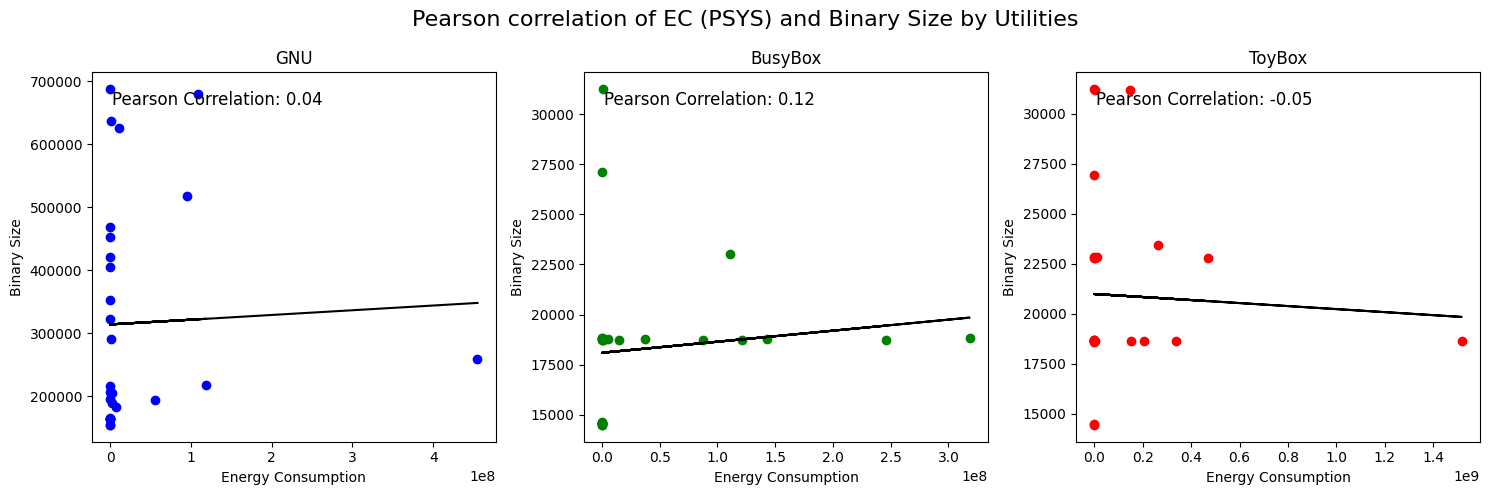

In [22]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['Size'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('Binary Size')
    axes[i].set_title(utility)

    # It calculate the Pearson correlation coefficient and shows it in the plot
    pearson_corr = utility_df[['PSYS', 'Size']].corr(method='pearson').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Pearson Correlation: {pearson_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['Size'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Pearson correlation of EC (PSYS) and Binary Size by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()


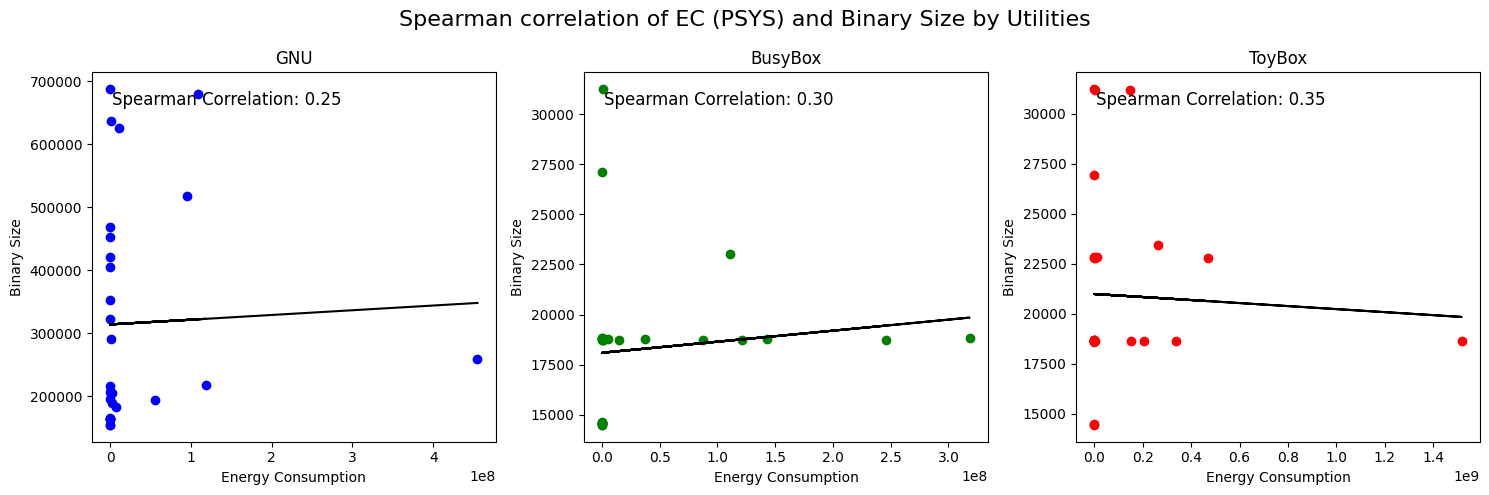

In [23]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['Size'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('Binary Size')
    axes[i].set_title(utility)

    # It calculates the Spearman correlation coefficient and show it in the plot
    spearman_corr = utility_df[['PSYS', 'Size']].corr(method='spearman').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Spearman Correlation: {spearman_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['Size'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Spearman correlation of EC (PSYS) and Binary Size by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

In [25]:
# Now we want to calculate the Peason correlation between the EC and Duration 
# for all utilities in each 3 different implementations

# The Spearman correlation with the p-value

import pandas as pd
from scipy.stats import spearmanr

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['DURATION']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Spearman Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

           Spearman Correlation       p-value
Utilities                                    
BusyBox                0.959496  7.983564e-16
GNU                    0.891078  2.070780e-10
ToyBox                 0.965517  1.019583e-16


In [26]:
# The Pearson correlation with the p-value

import pandas as pd
from scipy.stats import pearsonr

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: pearsonr(x['PSYS'], x['DURATION']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Pearson Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

           Pearson Correlation       p-value
Utilities                                   
BusyBox               0.998668  5.230304e-35
GNU                   0.998539  1.741551e-34
ToyBox                0.999771  6.001771e-45


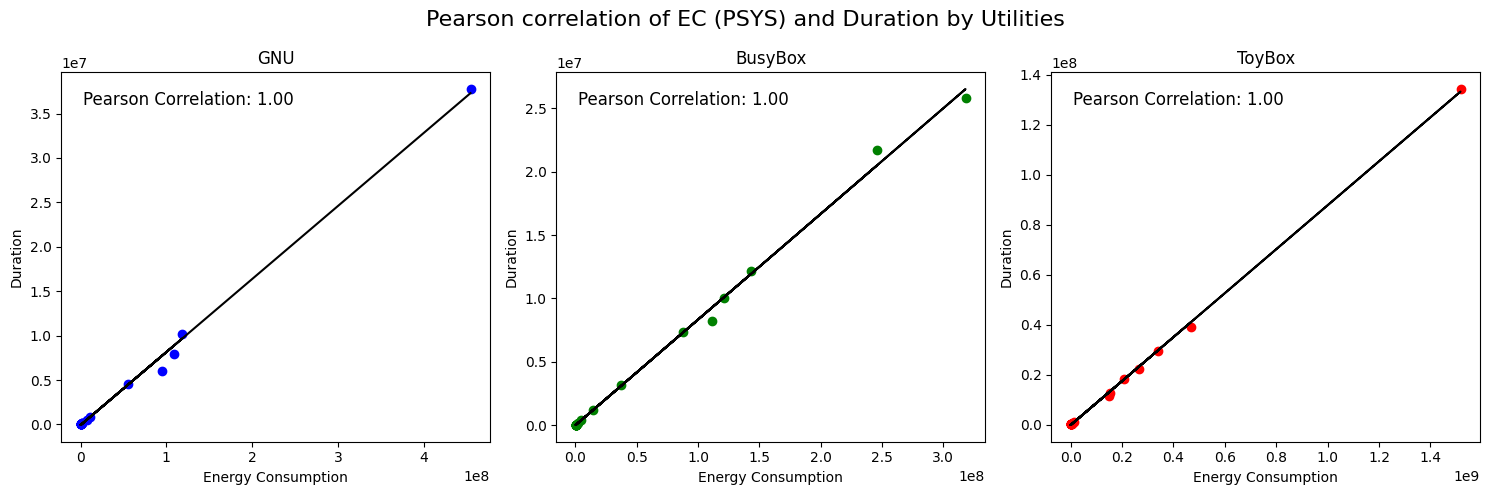

In [27]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['DURATION'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('Duration')
    axes[i].set_title(utility)

    # It calculate the Pearson correlation coefficient and shows it in the plot
    pearson_corr = utility_df[['PSYS', 'DURATION']].corr(method='pearson').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Pearson Correlation: {pearson_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['DURATION'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Pearson correlation of EC (PSYS) and Duration by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

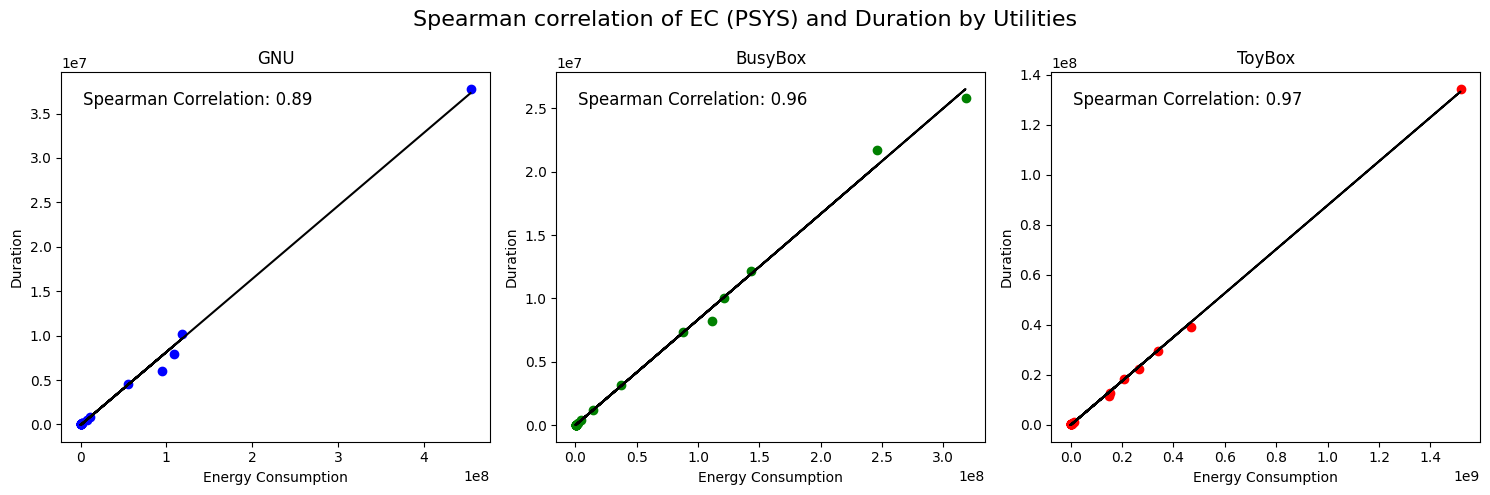

In [28]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['DURATION'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('Duration')
    axes[i].set_title(utility)

    # It calculates the Spearman correlation coefficient and show it in the plot
    spearman_corr = utility_df[['PSYS', 'DURATION']].corr(method='spearman').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Spearman Correlation: {spearman_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['DURATION'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Spearman correlation of EC (PSYS) and Duration by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

In [29]:
# Now we want to calculate the Peason correlation between the EC and Number of Configuration Options 
# for all utilities in each 3 different implementations

# The Spearman correlation with the p-value

import pandas as pd
from scipy.stats import spearmanr

input_data = os.path.join(results_dir, 'all_ec_options.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['Options']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Spearman Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

           Spearman Correlation   p-value
Utilities                                
BusyBox                0.270593  0.163709
GNU                    0.460888  0.013575
ToyBox                 0.391512  0.039370


In [30]:
# The Pearson correlation with the p-value

import pandas as pd
from scipy.stats import pearsonr

input_data = os.path.join(results_dir, 'all_ec_options.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: pearsonr(x['PSYS'], x['Options']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
correlation_df = pd.DataFrame({'Pearson Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(correlation_df)

           Pearson Correlation   p-value
Utilities                               
BusyBox               0.207760  0.288749
GNU                   0.080661  0.683256
ToyBox                0.120954  0.539807


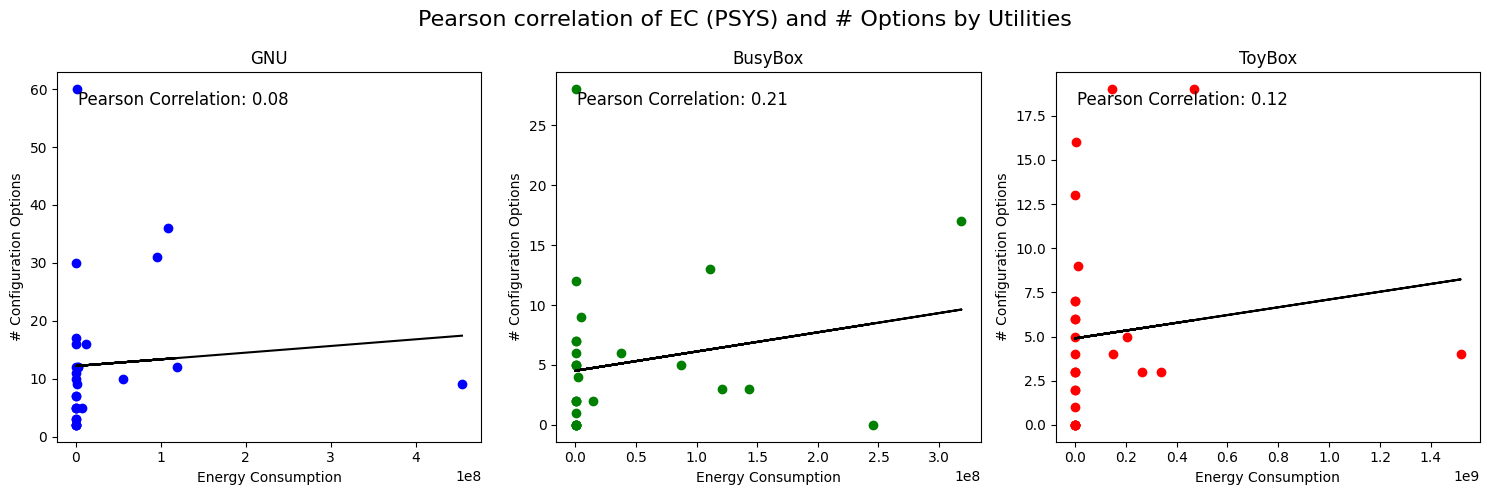

In [31]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_options.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['Options'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('# Configuration Options')
    axes[i].set_title(utility)

    # It calculate the Pearson correlation coefficient and shows it in the plot
    pearson_corr = utility_df[['PSYS', 'Options']].corr(method='pearson').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Pearson Correlation: {pearson_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['Options'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Pearson correlation of EC (PSYS) and # Options by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

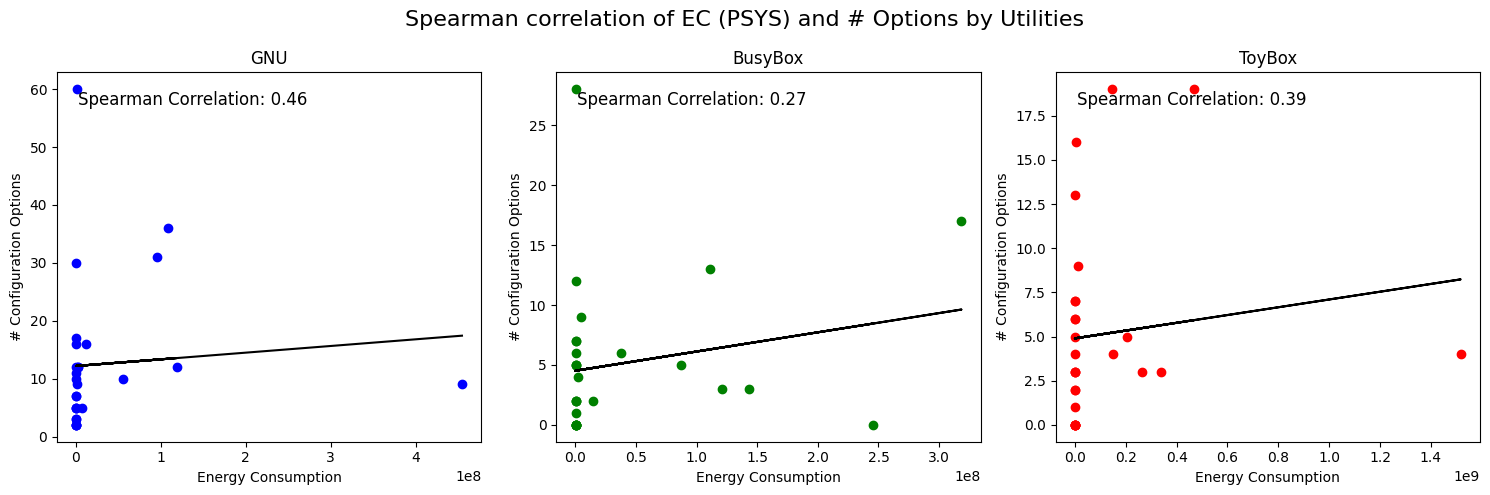

In [32]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_options.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['Options'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('# Configuration Options')
    axes[i].set_title(utility)

    # It calculates the Spearman correlation coefficient and show it in the plot
    spearman_corr = utility_df[['PSYS', 'Options']].corr(method='spearman').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Spearman Correlation: {spearman_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['Options'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Spearman correlation of EC (PSYS) and # Options by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()